In [1]:
import pandas as pd
from matplotlib import pylab
from scipy import linalg
import numpy as np

## Data import and plotting

Data is read from csv as a pandas dataframe. Row titles = (time, replicate), columns = features in the sample. 

In [24]:
df = pd.read_csv("timeseries_example2.csv", index_col=0)

The number of time points needs to be defined as the variable `m`, the number of replicates at each time point as variable `repl`.

In [3]:
m = 5
repl = 3

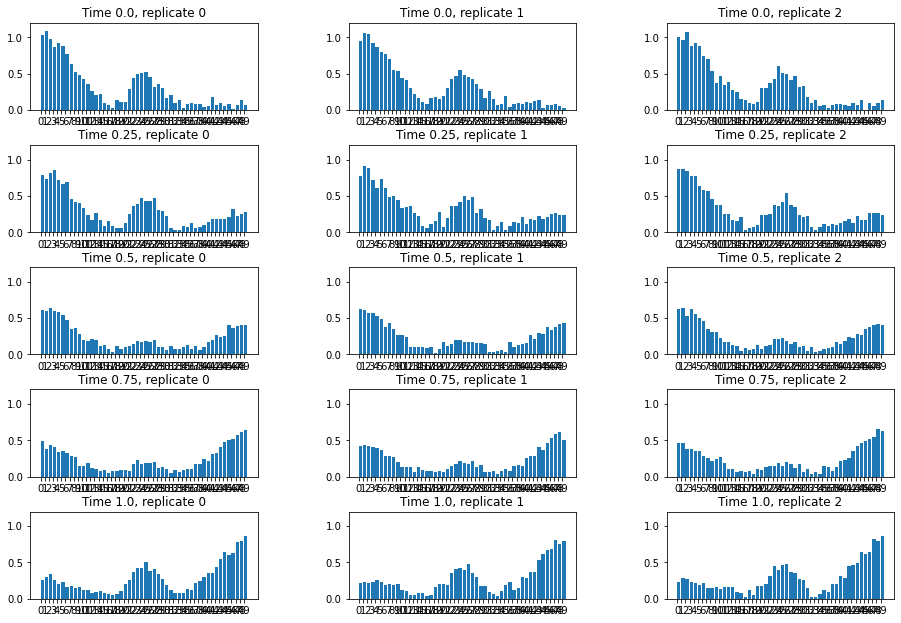

In [4]:
fig, axs = pylab.subplots(m, repl, figsize=(15,10))
for i in range(m):
    for j in range(repl):
        index = df.index[i*repl+j]
        axs[i,j].bar(df.columns, df.loc[index], align='edge')
        axs[i,j].set_ylim(0,1.2)
        axs[i,j].set_title('Time {}, replicate {}'.format(eval(index)[0], eval(index)[1]))

# adjust subplot size so that titles don't overlap -> https://stackoverflow.com/a/68158499
pylab.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

## Data rescaling to zero mean, unit variance

In [5]:
import sklearn
import sklearn.preprocessing

In [6]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(df)

StandardScaler()

In [7]:
data_scaled = scaler.transform(df)

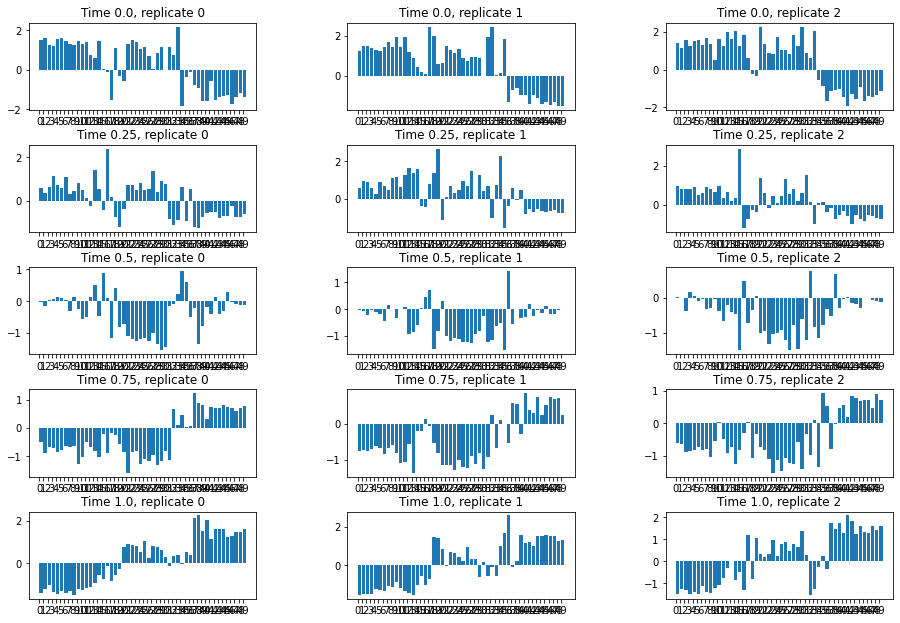

In [8]:
fig, axs = pylab.subplots(m, repl, figsize=(15,10))
for i in range(m):
    for j in range(repl):
        index = df.index[i*repl+j]
        axs[i,j].bar(df.columns, data_scaled[i*repl+j, :], align='edge')
        # axs[i,j].set_ylim(0,1.2)
        axs[i,j].set_title('Time {}, replicate {}'.format(eval(index)[0], eval(index)[1]))

# adjust subplot size so that titles don't overlap -> https://stackoverflow.com/a/68158499
pylab.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

The rescaled data is very noisy for the features in the middle. This will not be as reliable as the unscaled data. Probably the measurement noise (same noise level on all features irrespective of mean feature value) does not play well with scaling to unit variance for small feature values.

The below analysis rather uses the unscaled data to avoid issues with improper noise scaling.

## Data analysis with proper orthogonal decomposition

In [26]:
U, S, Vt = linalg.svd(np.asarray(df))
# U, S, Vt = linalg.svd(data_scaled)

In [27]:
U.shape

(15, 15)

In [29]:
S

array([8.85725179, 3.47653954, 1.07343956, 0.41948774, 0.37050148,
       0.35287565, 0.31855216, 0.26938672, 0.2521501 , 0.24648057,
       0.21880599, 0.20528945, 0.18837168, 0.1416057 , 0.13661951])

In [28]:
U[:,0]

array([-0.32207521, -0.3244926 , -0.32842021, -0.28771263, -0.29673459,
       -0.29363044, -0.2267601 , -0.22279711, -0.22434291, -0.20732622,
       -0.20122858, -0.20377781, -0.22802217, -0.21688652, -0.22503036])

Text(0.5, 0, 'Singular value index')

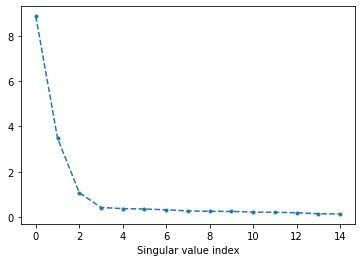

In [10]:
pylab.plot(S, '--.')
pylab.xlabel("Singular value index")

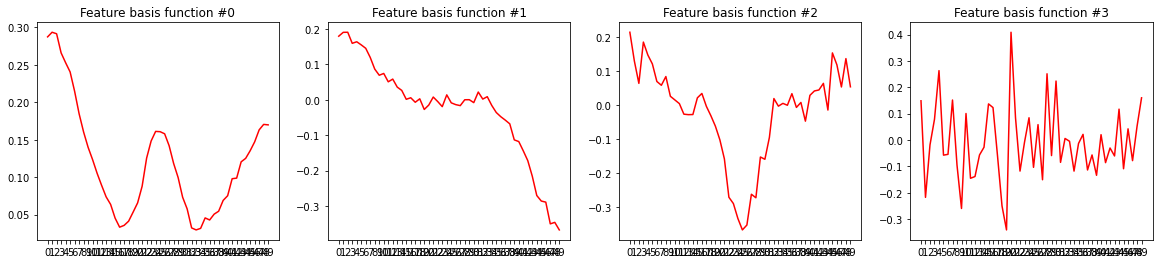

In [30]:
fig, axs = pylab.subplots(1, 4, figsize=(20,4))
axs[0].plot(df.columns, -Vt.T[:,0], 'r')
axs[1].plot(df.columns, -Vt.T[:,1], 'r')
axs[2].plot(df.columns, -Vt.T[:,2], 'r')
axs[3].plot(df.columns, -Vt.T[:,3], 'r')
for i,ax in enumerate(axs):
    ax.set_title("Feature basis function #{}".format(i))

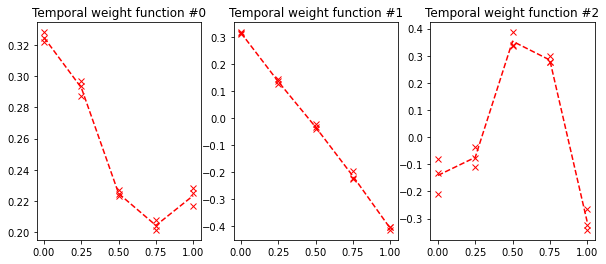

In [12]:
fig, axs = pylab.subplots(1, 3, figsize=(10,4))
timepoints = np.sort(list(set([float(eval(s)[0]) for s in df.index])))
R = np.zeros((m, m*repl))
for i in range(m):
    R[i, i*repl:(i+1)*repl] = np.ones(repl)
for i in range(repl):
    axs[0].plot(timepoints, -U[i::repl,0], 'rx')
axs[0].plot(timepoints, -R.dot(U[:,0])/repl, 'r--')
for i in range(repl):
    axs[1].plot(timepoints, -U[i::repl,1], 'rx')
axs[1].plot(timepoints, -R.dot(U[:,1])/repl, 'r--')
for i in range(repl):
    axs[2].plot(timepoints, -U[i::repl,2], 'rx')
axs[2].plot(timepoints, -R.dot(U[:,2])/repl, 'r--')

for i,ax in enumerate(axs):
    ax.set_title("Temporal weight function #{}".format(i))

Compare the reconstruction with the first 2 basis functions to the actual data:

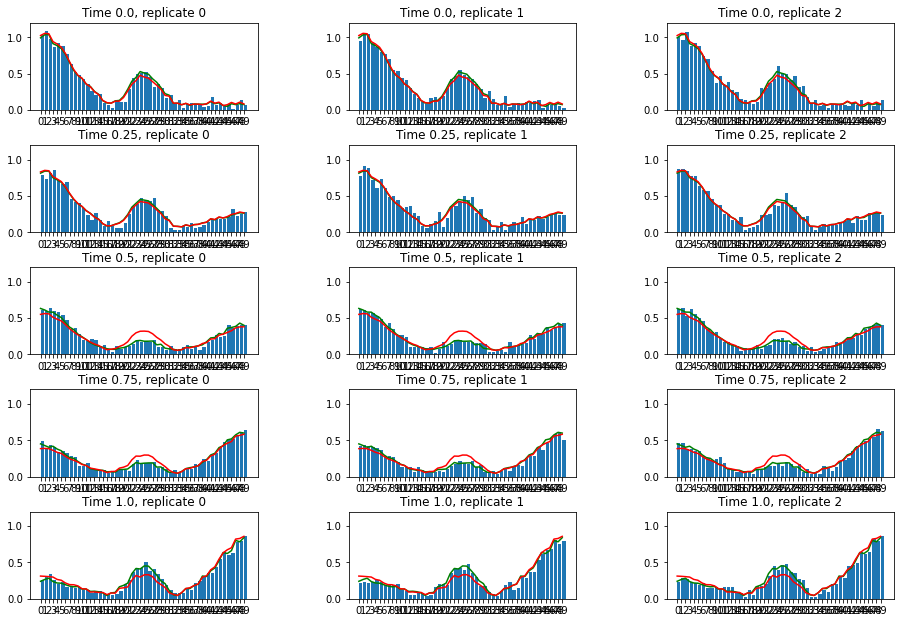

In [13]:
fig, axs = pylab.subplots(m, repl, figsize=(15,10))
for i in range(m):
    for j in range(repl):
        index = df.index[i*repl+j]
        axs[i,j].bar(df.columns, df.loc[index], align='edge')
        RU = R.dot(U)/repl
        recon = S[0] * RU[i,0] * Vt.T[:,0] + S[1] * RU[i,1] * Vt.T[:,1]
        recon3 = recon + S[2] * RU[i,2] * Vt.T[:,2]
        axs[i,j].plot(df.columns, recon3, 'g')
        axs[i,j].plot(df.columns, recon, 'r')
        axs[i,j].set_ylim(0,1.2)
        axs[i,j].set_title('Time {}, replicate {}'.format(eval(index)[0], eval(index)[1]))

# adjust subplot size so that titles don't overlap -> https://stackoverflow.com/a/68158499
pylab.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

## Time courses of components in POD/PCA plot

In [14]:
plot_features = {"0":'rx', "1":'rx', "24":'gx', "25":'gx', "48":'bx', "49":'bx'}

0 [0.82700294 0.74480177 0.5716146  0.51939189 0.56825474]
0 [ 0.19816764  0.08484133 -0.02065885 -0.13456385 -0.25580747]
1 [0.84477562 0.7608079  0.58389886 0.53055387 0.5804668 ]
1 [ 0.21019629  0.08999114 -0.02191283 -0.14273179 -0.27133482]
24 [0.46369785 0.41760792 0.32050244 0.29122134 0.31861858]
24 [ 0.0154592   0.00661853 -0.00161161 -0.01049742 -0.01995573]
25 [0.46257086 0.41659295 0.31972347 0.29051354 0.31784419]
25 [-0.00934539 -0.00400103  0.00097425  0.0063459   0.01206363]
48 [0.49058907 0.44182624 0.33908933 0.30811013 0.33709622]
48 [-0.38159646 -0.16337254  0.03978119  0.25911944  0.49258913]
49 [0.48883158 0.44024345 0.33787457 0.30700636 0.33588861]
49 [-0.40509721 -0.1734339   0.04223113  0.2750774   0.5229254 ]


Text(0, 0.5, 'PC 2')

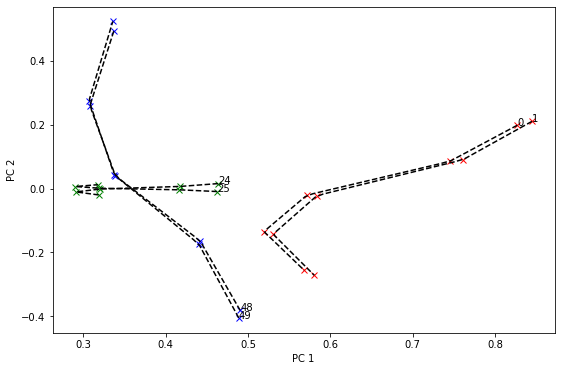

In [15]:
pylab.figure(figsize=(9,6))
for c in plot_features:
    index = df.columns.get_loc(c)
    traj_1 = RU[:,0] * Vt[0,index] * S[0]
    print(c, traj_1)
    traj_2 = RU[:,1] * Vt[1,index] * S[1]
    print(c, traj_2)
    pylab.plot(traj_1, traj_2, plot_features[c])
    pylab.annotate(c, ((traj_1[0], traj_2[0])))
    
# finely resolved plot -> interpolation on temporal weigth function
timepoints_fine = np.linspace(timepoints[0], timepoints[-1], num=50)
for c in plot_features:
    index = df.columns.get_loc(c)
    RU_interp0 = np.interp(timepoints_fine, timepoints, RU[:,0])
    traj_1 = RU_interp0 * Vt[0,index] * S[0]
    RU_interp1 = np.interp(timepoints_fine, timepoints, RU[:,1])
    traj_2 = RU_interp1 * Vt[1,index] * S[1]
    pylab.plot(traj_1, traj_2, 'k--')
    
pylab.xlabel("PC 1")
pylab.ylabel("PC 2")

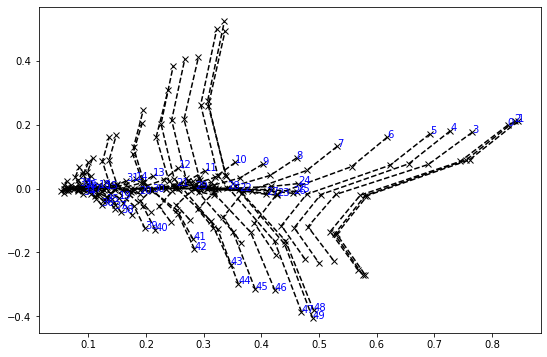

In [23]:
pylab.figure(figsize=(9,6))
for c in df.columns:
    index = df.columns.get_loc(c)
    traj_1 = RU[:,0] * Vt[0,index] * S[0]
    traj_2 = RU[:,1] * Vt[1,index] * S[1]
    pylab.plot(traj_1, traj_2, 'kx--')
    pylab.annotate(c, ((traj_1[0], traj_2[0])), c='b')

## Alternative: PCA per timepoint

In [18]:
df.columns.where?

In [19]:
data = df.iloc[:repl, :]
Up = m * [None,]
Sp = m * [None,]
Vtp = m * [None,]
for i in range(m):
    data = np.asarray(df.iloc[i*repl:(i+1)*repl, :])
    Up[i], Sp[i], Vtp[i] = linalg.svd(data.T.dot(data))

[2.85953120e+01 1.36298491e-01 7.37390258e-02 4.26613436e-15]
[2.09163771e+01 1.39780185e-01 1.13372804e-01 3.25339474e-15]
[1.23628022e+01 6.95824130e-02 3.44342555e-02 2.01073138e-15]
[1.17814048e+01 5.09949502e-02 3.95607481e-02 2.12495611e-15]
[1.81367397e+01 9.05806904e-02 4.88898983e-02 1.80370563e-15]


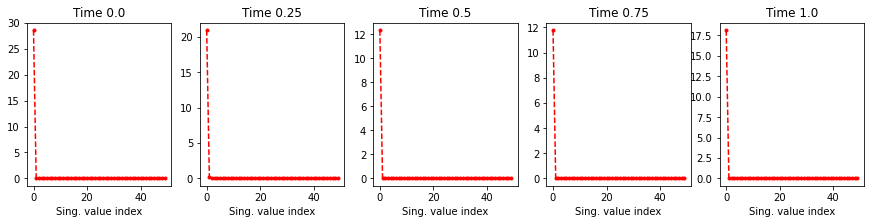

In [20]:
fig, axs = pylab.subplots(1, m, figsize=(15,3))
for i in range(m):
    print(Sp[i][:4])
    axs[i].plot(Sp[i], 'r.--')
    axs[i].set_title("Time {}".format(eval(df.index[i*repl])[0]))
    axs[i].set_xlabel("Sing. value index")

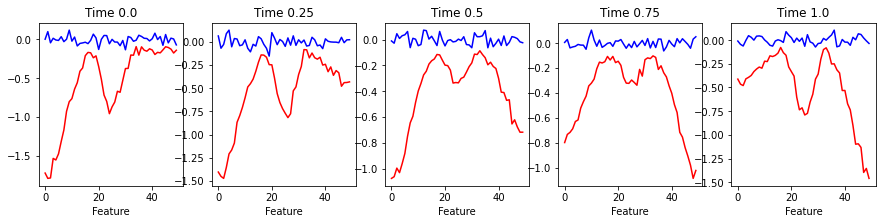

In [21]:
fig, axs = pylab.subplots(1, m, figsize=(15,3))
for i in range(m):
    axs[i].plot(np.sqrt(Sp[i][0])*Up[i][:,0], 'r')
    axs[i].plot(np.sqrt(Sp[i][1])*Up[i][:,1], 'b')
    axs[i].set_title("Time {}".format(eval(df.index[i*repl])[0]))
    axs[i].set_xlabel("Feature")

0 [-1.72703573 -1.40388131 -1.07608351 -0.79914741 -0.41220809]
0 [ 0.00335055  0.06007    -0.01113272  0.00501111 -0.01075607]
1 [-1.79585312 -1.45029981 -1.06286934 -0.73388356 -0.46542295]
1 [ 0.10134597 -0.07179201 -0.0285691   0.02849383 -0.04591715]
24 [-0.95929797 -0.72158458 -0.33329184 -0.32371737 -0.71501598]
24 [-0.05542755  0.00117212 -0.01445901 -0.00808075  0.02088723]
25 [-0.87129626 -0.77172376 -0.33566746 -0.2969175  -0.79043664]
25 [ 0.00143511 -0.05161679  0.00289921 -0.03664894 -0.065847  ]
48 [-0.17516238 -0.44040213 -0.71823504 -1.08669436 -1.35433748]
48 [ 0.00637732  0.01824542 -0.01822808  0.03142132 -0.00849644]
49 [-0.13963465 -0.43383067 -0.71808589 -1.02310961 -1.4593796 ]
49 [-0.0700744   0.01968099 -0.02486145  0.05052207 -0.03585281]


Text(0, 0.5, 'PC 2')

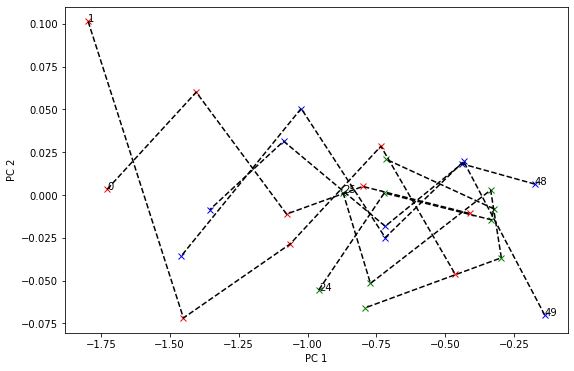

In [22]:
pylab.figure(figsize=(9,6))
for i in range(m):
    pc1 = np.zeros(len(plot_features))
    pc1 = np.sqrt(Sp[i][0]) * np.asarray([Up[i][df.columns.get_loc(c),0] for c in plot_features])
    pc2 = np.zeros(len(plot_features))
    pc2 = np.sqrt(Sp[i][1]) * np.asarray([Up[i][df.columns.get_loc(c),1] for c in plot_features])
    for i,c in enumerate(plot_features):
        pylab.plot(pc1[i], pc2[i], plot_features[c])
for c in plot_features:
    pc1 = np.asarray([np.sqrt(Sp[i][0]) * Up[i][df.columns.get_loc(c),0] for i in range(m)])
    pc2 = np.asarray([np.sqrt(Sp[i][1]) * Up[i][df.columns.get_loc(c),1] for i in range(m)])
    print(c, pc1)
    print(c, pc2)
    pylab.plot(pc1, pc2, 'k--')
    pylab.annotate(c, ((pc1[0], pc2[0])))
pylab.xlabel("PC 1")
pylab.ylabel("PC 2")

In [35]:
r = linalg.svd(np.random.randn(100, 10000))

In [36]:
U, S, V = r

In [37]:
S

array([109.91238022, 109.38165379, 109.04930144, 108.59167956,
       108.21000396, 107.99932506, 107.87773445, 107.73598113,
       107.19305634, 106.82547569, 106.62704128, 106.35957306,
       106.18187208, 106.03477059, 105.90575325, 105.71609795,
       105.50101151, 105.23914507, 104.98328651, 104.89699633,
       104.50784132, 104.29850925, 104.26872861, 103.97591676,
       103.87222272, 103.59999026, 103.52716912, 103.37126143,
       103.19298095, 103.12022768, 103.03408788, 102.96883539,
       102.83372863, 102.53357013, 102.44205961, 102.25903115,
       101.82462892, 101.70837844, 101.60546623, 101.5179563 ,
       101.39781878, 101.25241326, 101.11313375, 101.01229683,
       100.82298648, 100.67086001, 100.29721409, 100.23893556,
        99.87720372,  99.77109029,  99.56081724,  99.44994445,
        99.33532094,  99.23209027,  99.06150047,  98.97688151,
        98.85337624,  98.62283198,  98.37823383,  98.12879576,
        97.99883878,  97.95341292,  97.87409575,  97.62

Text(0.5, 0, 'Singular value index')

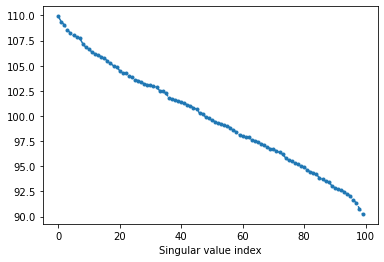

In [38]:
pylab.plot(S, '--.')
pylab.xlabel("Singular value index")